<a href="https://colab.research.google.com/github/seodalzzz/NBA_analysis/blob/main/NBA_%EA%B2%BD%EA%B8%B0%EC%9D%98_%EC%A0%84%EB%B0%98%EC%A0%84_%EC%84%B8%EB%B6%80_%EC%8A%A4%ED%83%AF%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EA%B8%B0%EB%8C%80_%EC%8A%B9%EB%A5%A0_%EB%B0%8F_%EC%8A%B9%EB%B6%80_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NBA 경기의 전반전 세부 스탯을 이용한 기대 승률 및 승부 예측**

@seodalzzz

data from : https://www.basketball-reference.com/

**아래 세번째 코드 셀의 path에 데이터 경로 입력하시면 됩니다.**

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 데이터가 저장된 경로 입력
path="/content/drive/MyDrive/ASDA/TermProject/basketballData/Real/2020-2023_TOT.csv"

In [4]:
#warning 출력 숨기기
#https://wotres.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%97%90%EC%84%9C-warning-%EC%95%88%EB%B3%B4%EC%9D%B4%EA%B2%8C-%ED%95%98%EB%8A%94%EB%B2%95
import warnings
warnings.filterwarnings(action='ignore')

---

## **1. Introduction**

현재 한국프로농구(KBL)는 2022-2023시즌이 한창 진행중이다. 본인은 KBL 경기를 매우 열심히 챙겨보는 팬 중 한 명으로, 지난 시즌에만 총 41경기를 '직관(직접 관람)'했을 정도로 실제 경기장에도 꽤 자주 방문하는 편이다. 그런데 경기를 보기 위해 경기장에 방문할 때마다 궁금한 것이 하나 있었다. 바로, 전반전이 끝나면 핸드폰에서 울리는 KBL 통합 어플리케이션의 '2Q 종료 후 기대 승률' 알림 이었다. KBL에서 실제 경기장에 입장한 관람객을 대상으로 경기 전반전이 끝난 시점에서 해당 경기의 기대 승률을 홈팀 기준으로 알려주는 것이다. 자세한 내용은 아래 사진과 같다.
<p align="center"><img src="https://velog.velcdn.com/images/seodalzzz/post/781aa74c-80e7-44e2-bd33-45e783303eae/image.png" height="500"></p>

본인은 이 알림을 볼 때마다 "이 2Q 종료 후 기대 승률은 대체 어떤 방법으로 구하는걸까?" 라는 궁금증이 들었다. 본인이 지금까지 받은 알림을 토대로 생각해 보면, 득점이 실점보다 많으면 해당 기대 승률은 50% 이상이고, 득점과 실점의 차이가 적을수록 50%에 가까운 값을 가진다. 또한 해당 기대 승률은 전반전의 득점/실점에 매우 의존적인 것으로 보였다. 농구는 단순히 득점을 더 많이 하면 이기는 게임이기 때문에 어쩌면 정말 당연한 이야기일 수 도 있다. 하지만 분명 야투율이나 턴오버 갯수, 리바운드 갯수 등의 다른 요인들도 득점 못지 않게 중요한 역할을 할 것이다. KBL에서 제공하는 기존의 기대 승률도 이러한 부가 스탯들을 사용할 것으로 생각되기는 하지만, 현재는 별도의 설명 없이 단순히 기대 승률만 제공되기 때문에 해당 기대승률 지표에 대해 정확히 파악하는 것에 어려움이 있다. 이에 직접 전반전 데이터를 이용하여 농구 경기의 기대 승률을 예측하고, 나아가 해당 경기의 승부까지 예측하는 프로젝트를 진행하였다.



## **2. DataSet**

 프로젝트 동기가 KBL의 '2Q 종료 후 기대 승률' 이었고, 본인의 주 관심사 역시 KBL이기 때문에 KBL의 데이터로 프로젝트를 진행하고자 시도하였다. 하지만 현재 KBL 에서는 쿼터별 데이터로는 득점 데이터만 제공한다. 리바운드 갯수, 야투율과 같은 경기 세부 스탯의 경우 경기 전체(4쿼터 전체) 데이터만 제공하고 쿼터별(혹은 전/후반 별) 데이터는 제공하지 않는다.(홈페이지의 경기 기록 메뉴에서 해당 데이터가 제공되지 않아 KBL측에 따로 문의하였으나 홈페이지에서 제공하는 데이터 외에는 제공이 어렵다는 답변을 받았다.) 하지만 본 프로젝트에서는 앞서 언급한 것 처럼 기대 승률 및 승부 예측에 전반전의 세부 스탯들을 적용하고자 하기 때문에 최소한 경기의 전/후반으로 구분된 팀별 세부 스탯 데이터가 필요했다.

이에 동일한 내용의 프로젝트를 KBL이 아닌 NBA 데이터를 활용하여 진행키로 결정하였다. NBA 경기의 경우 Basketball-Reference 라는 NBA 관련 데이터를 제공하는 사이트가 존재하고, 해당 사이트에서 아래 사진과 같이 각 경기에 대한 팀별 전/후반 혹은 쿼터별 세부 스탯을 확인할 수 있다.

<p align="center"><img src="https://velog.velcdn.com/images/seodalzzz/post/a3347a66-b4d1-4fea-aea9-83d8dbf69fa0/image.png" height="400"></p>

<p align="center"><img src="https://velog.velcdn.com/images/seodalzzz/post/2aa3cff3-71d4-4b03-83ba-d6286b4d0739/image.png" height="400"></p>




하지만 해당 basketball-reference 사이트 역시 data를 보여주기만 할 뿐, 유저가 원하는 형태의 데이터를 뽑아 다운받을 수 있는 시스템은 아니다. 이에 BeautifulSoup 패키지를 사용하여 web scraping을 통해 각 경기의 팀별 전반 세부 스탯 데이터를 뽑아 필요한 데이터셋을 생성하는 코드를 작성했다. 코드는 다음과 같다.



```
# needed libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import numpy as np
```

```
STAT=pd.DataFrame(columns=['Team_H','Team_A','HomeWin',
                            'MP_H','FG_H','FGA_H','FG%_H','3P_H','3PA_H','3P%_H','FT_H','FTA_H','FT%_H','ORB_H','DRB_H','TRB_H','AST_H','STL_H','BLK_H','TOV_H','PF_H','PTS_H',
                           'MP_A','FG_A','FGA_A','FG%_A','3P_A','3PA_A','3P%_A','FT_A','FTA_A','FT%_A','ORB_A','DRB_A','TRB_A','AST_A','STL_A','BLK_A','TOV_A','PF_A','PTS_A'])

basic_url="https://www.basketball-reference.com"
date_url="https://www.basketball-reference.com/boxscores/?month=5&day=16&year=2021"

while (STAT.shape[0]<=1230):
  urls=[]
  response = requests.get(date_url)
  soup=BeautifulSoup(response.text,"html.parser")

  for suburl in soup.find_all("td",{"class":"right gamelink"}):
    urls.append(basic_url+suburl.find("a").get('href'))

  for j in range(len(urls)):
    response_temp=requests.get(urls[j])
    print(urls[j])
    soup_temp=BeautifulSoup(response_temp.text, 'html.parser')

    soup_strong=soup_temp.find_all("strong")
    for k in range(len(soup_strong)):
      if(len(soup_strong[k].get_text())==3):
        home_team=soup_strong[k].get_text()
        away_team=soup_strong[k+1].get_text()
        break;
    
    score_list=soup_temp.find_all("div",{"class":"score"})
    score=[]
    for eachscore in score_list:
      score.append(eachscore.get_text())
    if score[0]>score[1]:
      homewin="1"
    else:
      homewin="0"

    class1=soup_temp.select('div#div_box-'+home_team+'-h1-basic table#box-'+home_team+'-h1-basic tfoot td')
    class2=soup_temp.select('div#div_box-'+away_team+'-h1-basic table#box-'+away_team+'-h1-basic tfoot td')
    df=[]
    df.append(home_team)
    df.append(away_team)
    df.append(homewin)

    for i in range(len(class1)-1):
      df.append(class1[i].get_text())
    for i in range(len(class2)-1):
      df.append(class2[i].get_text())

    STAT.loc[STAT.shape[0]]=df
    num=np.random.rand(1)[0]*5
    time.sleep(num)
    print(STAT.shape[0])
  prev_url=soup.find("div",{"class":"prevnext"}).find("a").get('href')
  date_url=basic_url+prev_url

STAT.head(10)
STAT.tail(10)
```


> scraping 코드 작성에 참고한 자료 : https://youtu.be/TbPD9Ndnt04

코드의 date_url에 아래 사진과 같은 특정 날짜의 경기 결과가 모여있는 페이지의 url을 입력하고 코드를 실행시키면 해당 날짜로부터 하루씩 이전으로 가면서 각 날짜에 실시된 경기 별로 홈팀/원정팀의 전반 세부 스탯과 경기 결과를 scraping하여 STAT 데이터프레임에 추가한다.

<p align="center"><img src="https://velog.velcdn.com/images/seodalzzz/post/5b1e49d2-b5b8-46a9-949c-67262843e213/image.png
" height="400"></p>

전체 scraping은 시즌 단위로 진행된다. 각 시즌의 마지막 경기 날짜에 대한 페이지 URL을 date_url에 입력하고 while문의 조건을 (STAT.shape[0]<=해당시즌의총경기수) 로 설정하면 해당 시즌의 모든 경기에 대해 경기별 전반전 세부 스탯 데이터를 scragping 하여 하나의 데이터프레임으로 만들 수 있다. 기존 NBA는 30개 팀이 82경기씩 치러 총 1,230 경기가 치러지지만 2022-2023 시즌은 현재 진행중이기 때문에 경기 수가 1230 보다 적고, 2020-2021시즌은 COVID19의 여파로 팀별로 10경기씩 적게 진행되어 총 1080 경기가 진행되었다.(72x30/2=1080) . 이렇게 생성한 2020-2021, 2021-2022, 2022-2023 시즌의 데이터를 csv 파일로 저장한 뒤 하나의 파일로 합쳐 프로젝트에 사용하였다. 단, 플레이오프 경기는 특성상 예외적인 사항이 많이 발생하기 때문에 정규리그 경기의 데이터만 사용하였다.

## **3. EDA**

### **1) Data Load**

* 데이터를 불러오기 위해 해당 보고서의 시작 부분에 있는 path 에 입력해둔 경로를 사용한다.

In [19]:
basket=pd.read_csv(path)
basket=basket.drop(basket.columns[0],axis=1)

In [20]:
basket.head(10)

,Team_H,Team_A,HomeWin,MP_H,FG_H,FGA_H,FG%_H,3P_H,3PA_H,3P%_H,...,FT%_A,ORB_A,DRB_A,TRB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,PTS_A
0,DAL,CLE,1,120,18,43,0.419,7,21,0.333,...,0.600,5,22,27,11,5,4,6,11,47
1,POR,HOU,0,120,21,44,0.477,5,15,0.333,...,0.727,11,17,28,12,3,4,8,12,51
2,WAS,LAC,1,120,24,42,0.571,6,14,0.429,...,0.750,4,15,19,11,3,2,7,4,50
3,UTA,MIL,1,120,18,45,0.400,10,25,0.400,...,1.000,9,23,32,14,3,3,7,4,56
4,MEM,OKC,0,120,12,44,0.273,4,21,0.190,...,0.733,5,27,32,17,4,0,5,12,64
5,NOP,PHO,0,120,26,46,0.565,7,15,0.467,...,0.667,5,15,20,10,3,3,4,6,46
6,MIA,SAS,1,120,20,42,0.476,5,16,0.312,...,0.733,5,18,23,17,5,3,7,9,55
7,ORL,BOS,1,120,22,50,0.440,6,20,0.300,...,0.917,2,17,19,11,2,6,7,13,54
8,NYK,CHI,0,120,20,51,0.392,10,23,0.435,...,0.833,0,18,18,14,1,1,10,12,53
9,ATL,CHO,1,120,25,40,0.625,9,18,0.500,...,0.667,9,12,21,13,4,3,6,13,59


In [21]:
basket.shape

(2761, 41)

* 총 2,761 경기에 대한 데이터가 존재하며, 각 경기에 대해 홈팀/원정팀 각각 19개의 세부 스탯을 사용한다. 따라서 총 38개의 세부스탯과 홈팀/원정팀 을 나타내는 feature 2개, 경기 결과 feature까지 총 41개의 feature가 존재한다.

In [22]:
basket.columns

Index(['Team_H', 'Team_A', 'HomeWin', 'MP_H', 'FG_H', 'FGA_H', 'FG%_H', '3P_H',
       '3PA_H', '3P%_H', 'FT_H', 'FTA_H', 'FT%_H', 'ORB_H', 'DRB_H', 'TRB_H',
       'AST_H', 'STL_H', 'BLK_H', 'TOV_H', 'PF_H', 'PTS_H', 'MP_A', 'FG_A',
       'FGA_A', 'FG%_A', '3P_A', '3PA_A', '3P%_A', 'FT_A', 'FTA_A', 'FT%_A',
       'ORB_A', 'DRB_A', 'TRB_A', 'AST_A', 'STL_A', 'BLK_A', 'TOV_A', 'PF_A',
       'PTS_A'],
      dtype='object')

### **2) Features**
같은 세부 스탯에 대해 홈팀에 대한 feature와 원정팀에 대한 feature가 각각 존재한다. 따라서 feature 설명은 세부 스탯별로 한번씩만 진행한다. 홈팀에 대한 feature 명은 "세부스탯명_H"이고, 원정팀에 대한 feature명은 "세부스탯명_A"이다.
* Team : 경기 대상인 각 팀을 의미하며, 팀명 대신 대문자 알파벳 3개로 나타나는 팀별 표기명을 사용한다.
* HomeWin : 홈팀이 이겼는지의 여부를 나타내는 feature이다. 홈팀이 승리한 경기의 경우 1, 홈팀이 패배한 경기의 경우 0 값을 가진다.
  * 우리 모델의 label으로 사용할 feature이다.
  * KBL에서 제공하는 2Q 종료 후 기대 승률은 해당 경기의 홈팀을 기준으로 제공된다. 즉, 홈팀의 승률을 제공한다. (홈팀의 득점이 실점보다 많을수록 기대 승률이 높아진다.) 따라서 우리가 사용할 NBA데이터의 label 역시 홈팀의 승리 여부를 기준으로 설정하였다.
* MP : Minutes Played
  * 각 선수들이 경기에 뛴 시간을 모두 합한 것이다.
  * NBA는 한 쿼터 당 12분씩 경기를 하고, 한번에 팀당 5명의 선수가 출전하므로 전반전의 총 MP는 팀별 120으로 일정한 상수이다. (12x2x5=120)
  * 팀과 경기에 관계 없이 항상 같은 수치를 가지므로 삭제한다.
* FG : Field Goals
  * 코트 내에서 슛을 던졌을 때 해당 슛이 골이 된 횟수 (총 야투 성공 횟수)
  * 2점슛, 3점슛 모두 포함
  * 자유투(1점)은 제외
* FGA : Field Goal Attempts
  * 총 야투 시도 횟수 (슛을 던진 횟수)
  * 2점슛, 3점슛 모두 포함
  * 자유투 제외
* FG% : Field Goal Percentage
  * 총 야투 성공률
  * FG/FGA
* 3P : 3-Point Field Goals
  * 3점 야투 성공 횟수
* 3PA : 3-Point Field Goal Attempts
  * 3점 야투 시도 횟수
* 3P% : 3-Point Field Goal Percentage
  * 3점 야투 성공률
  * 3P/3PA
* FT : Free Throws
  * 자유투 성공 횟수
  * 1점
* FTA : Free Throw Attempts
  * 자유투 시도 횟수
* FT% : Free Throw Percentage
  * 자유투 성공률
  * FT/FTA
* ORB : Offensive Rebounds
  * 공격리바운드 수
  * 공격리바운드 : 공격 야투 시도 및 실패 후 공격을 시도한 팀의 선수가 리바운드를 따낸 경우
* DRB : Defensive Rebounds
  * 수비리바운드 수
  * 수비리바운드 : 공격 야투 시도 및 실패 후 공격을 시도하지 않은 팀 (수비를 하고 있던 팀)의 선수가 리바운드를 따낸 경우
* TRF : Total Rebounds
  * 총 리바운드 수
  * ORB+DRB
* AST : Assists
  * 어시스트 수
* STL : Steals
  * 스틸 : 상대가 공격중일 때 파울 없이 상대의 공을 가로채 공격권을 가져오는 것
* BLK : Blocks
  * 블락 : 수비자가 반칙을 하지 않고 공격자가 슛한 공을 쳐낸 것
* TOV : Turnovers
  * 턴오버 : 공격을 하던 팀이 패스 실수, 상대의 스틸 등으로 공격권을 빼앗기는 것
* PF : Personal Fouls
  * 파울 횟수
  * 한 쿼터에서 팀 통틀어 4회 이상 파울 시 다음 파울부터는 상대팀에게 자유투가 주어진다.
* PTS : Points
  * 총 득점
  * (FG-3P)x2+3Px3+FT=PTS


### **3) Data Summarise**

#### (1) Summary Statistics

In [23]:
basket.describe()

,HomeWin,MP_H,FG_H,FGA_H,FG%_H,3P_H,3PA_H,3P%_H,FT_H,FTA_H,...,FT%_A,ORB_A,DRB_A,TRB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,PTS_A
count,2761.000000,2761.0,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,...,2747.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000
mean,0.479174,120.0,20.943861,45.116987,0.465240,6.290837,17.416154,0.359101,7.719305,9.948207,...,0.778394,5.035494,17.530243,22.565737,13.006157,3.783412,2.450561,6.651576,9.001811,56.864180
std,0.499657,0.0,3.549255,4.076586,0.073966,2.571687,4.105442,0.117582,3.726786,4.424798,...,0.151642,2.513336,3.591946,4.307657,3.402945,1.968822,1.624708,2.609821,2.555258,8.694786
min,0.000000,120.0,9.000000,32.000000,0.204000,0.000000,5.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,6.000000,10.000000,3.000000,0.000000,0.000000,0.000000,1.000000,27.000000
25%,0.000000,120.0,19.000000,42.000000,0.415000,4.000000,15.000000,0.278000,5.000000,7.000000,...,0.684000,3.000000,15.000000,20.000000,11.000000,2.000000,1.000000,5.000000,7.000000,51.000000
50%,0.000000,120.0,21.000000,45.000000,0.465000,6.000000,17.000000,0.360000,7.000000,9.000000,...,0.800000,5.000000,17.000000,22.000000,13.000000,4.000000,2.000000,7.000000,9.000000,57.000000
75%,1.000000,120.0,23.000000,48.000000,0.519000,8.000000,20.000000,0.438000,10.000000,13.000000,...,0.882000,7.000000,20.000000,25.000000,15.000000,5.000000,3.000000,8.000000,11.000000,63.000000
max,1.000000,120.0,32.000000,59.000000,0.714000,17.000000,33.000000,0.750000,23.000000,28.000000,...,1.000000,15.000000,29.000000,39.000000,27.000000,13.000000,11.000000,17.000000,19.000000,89.000000


* MP feature의 경우 상수값을 가진다.

#### (2) NA값 확인

In [24]:
basket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2761 entries, 0 to 2760
Data columns (total 41 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Team_H   2761 non-null   object 
 1   Team_A   2761 non-null   object 
 2   HomeWin  2761 non-null   int64  
 3   MP_H     2761 non-null   int64  
 4   FG_H     2761 non-null   int64  
 5   FGA_H    2761 non-null   int64  
 6   FG%_H    2761 non-null   float64
 7   3P_H     2761 non-null   int64  
 8   3PA_H    2761 non-null   int64  
 9   3P%_H    2761 non-null   float64
 10  FT_H     2761 non-null   int64  
 11  FTA_H    2761 non-null   int64  
 12  FT%_H    2756 non-null   float64
 13  ORB_H    2761 non-null   int64  
 14  DRB_H    2761 non-null   int64  
 15  TRB_H    2761 non-null   int64  
 16  AST_H    2761 non-null   int64  
 17  STL_H    2761 non-null   int64  
 18  BLK_H    2761 non-null   int64  
 19  TOV_H    2761 non-null   int64  
 20  PF_H     2761 non-null   int64  
 21  PTS_H    2761 

In [25]:
basket.isna().sum()

Team_H      0
Team_A      0
HomeWin     0
MP_H        0
FG_H        0
FGA_H       0
FG%_H       0
3P_H        0
3PA_H       0
3P%_H       0
FT_H        0
FTA_H       0
FT%_H       5
ORB_H       0
DRB_H       0
TRB_H       0
AST_H       0
STL_H       0
BLK_H       0
TOV_H       0
PF_H        0
PTS_H       0
MP_A        0
FG_A        0
FGA_A       0
FG%_A       0
3P_A        0
3PA_A       0
3P%_A       0
FT_A        0
FTA_A       0
FT%_A      14
ORB_A       0
DRB_A       0
TRB_A       0
AST_A       0
STL_A       0
BLK_A       0
TOV_A       0
PF_A        0
PTS_A       0
dtype: int64

* FT%_H와 FT%_A feature에 NA값이 존재한다. 해당 feature에 NA값이 존재하는 경기를 실제 사이트에서 찾아본 결과, 전반전동안 해당 팀의 자유투 시도 횟수(FT_H 혹은 FT_A)가 0이기 때문에 자유투 성공률(FT%_H 혹은 FT_A%)이 NA값을 가진다.

### **4) EDA**

#### (1) feature 별 분포 확인

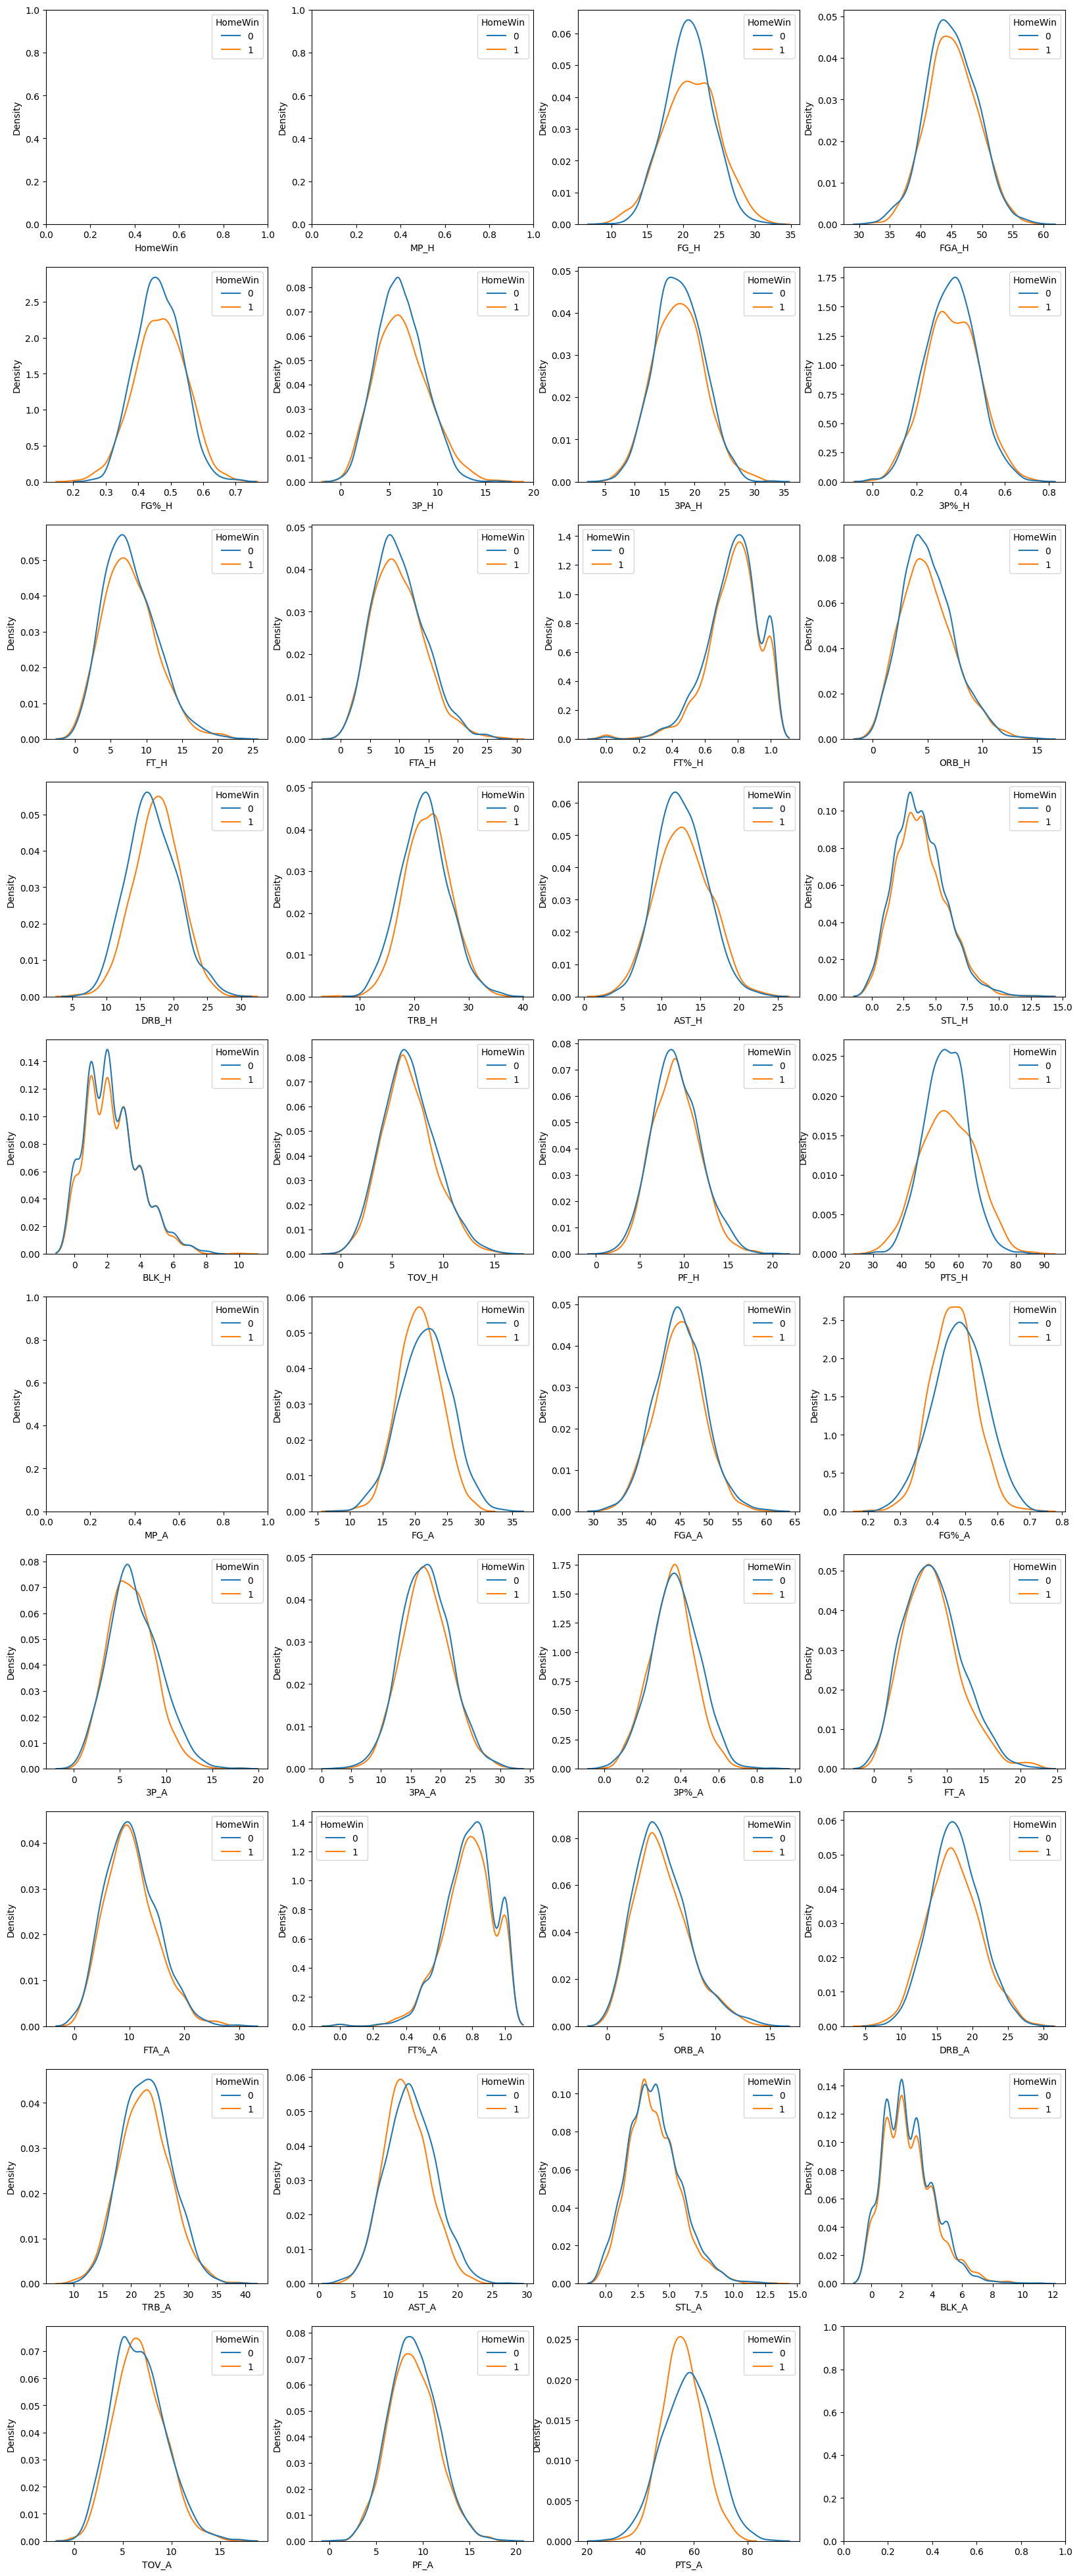

In [26]:
col_n = 4
row_n = 10

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*5))

for i,col in enumerate(basket.columns[2:]):
    sns.kdeplot(x=basket[col],data=basket, ax=ax[int(i/col_n),int(i%col_n)], hue="HomeWin")

* 각 변수의 분포 자체는 승리/패배 여부에 관계없이 비슷하며, 거의 정규분포 형태를 가진다.

* right skewed 형태를 띠는 다음 변수들은 log transformation을 고려해볼만 하다.
  * FT_H / FT_A
  * FTA_H / FTA_A
  * ORB_H / ORB_A
  * STL_H / STL_A
  * BLK_H / BLK_A
* 그러나 BLK_H와 BLK_A를 제외하고는 skewed된 정도가 그리 심하지 않기 때문에 추후 BLK_H와 BLK_A만 log transformation을 진행한다.

* left skewed 형태를 띠는 'FT%_H','FT%_A'는 square transformation을 진행한다.

* 경기 결과는 홈팀/원정팀의 상대적인 스탯에 따라 결정되기 때문에 홈팀이 원정팀에 '비해'얼마나 잘 했는지가 중요하다. 홈팀의 경기 승리 여부에 따라 홈팀과 원정팀의 스탯 차이 분포에 차이가 있는지 확인해 볼 필요가 있다.
  * 득점(PTS), 야투율(FG%,3P%), 리바운드(TRB) 총 4가지의 주요 스탯에 대해서만 홈/원정 팀의 스탯 차이를 나타내는 변수들로 이루어진 데이터프레임을 생성하여 확인한다.
  * 추후 모델 fitting에서는 홈팀의 스탯과 원정팀의 스탯이 함께 고려되기 때문에 홈팀과 원정팀의 스탯 차이를 나타내는 feature를 만들 필요까지는 없을 것으로 보인다.

In [27]:
basket_diff=pd.DataFrame(columns=['PTS','FG%','3P%','TRB','HomeWin'])
basket_diff['HomeWin']=basket['HomeWin']
basket_diff['PTS']=basket['PTS_H']-basket['PTS_A']
basket_diff['FG%']=basket['FG%_H']-basket['FG%_A']
basket_diff['3P%']=basket['3P%_H']-basket['3P%_A']
basket_diff['TRB']=basket['TRB_H']-basket['TRB_A']
basket_diff.head(10)

,PTS,FG%,3P%,TRB,HomeWin
0,2,0.002,0.122,-4,1
1,6,0.073,0.274,-9,0
2,7,0.188,-0.071,5,1
3,-9,-0.069,0.100,-16,1
4,-21,-0.156,-0.360,-6,0
5,17,0.201,0.206,4,0
6,-3,0.057,-0.188,-4,1
7,8,0.001,0.020,12,1
8,5,-0.191,-0.027,5,0
9,16,0.205,0.091,-1,1


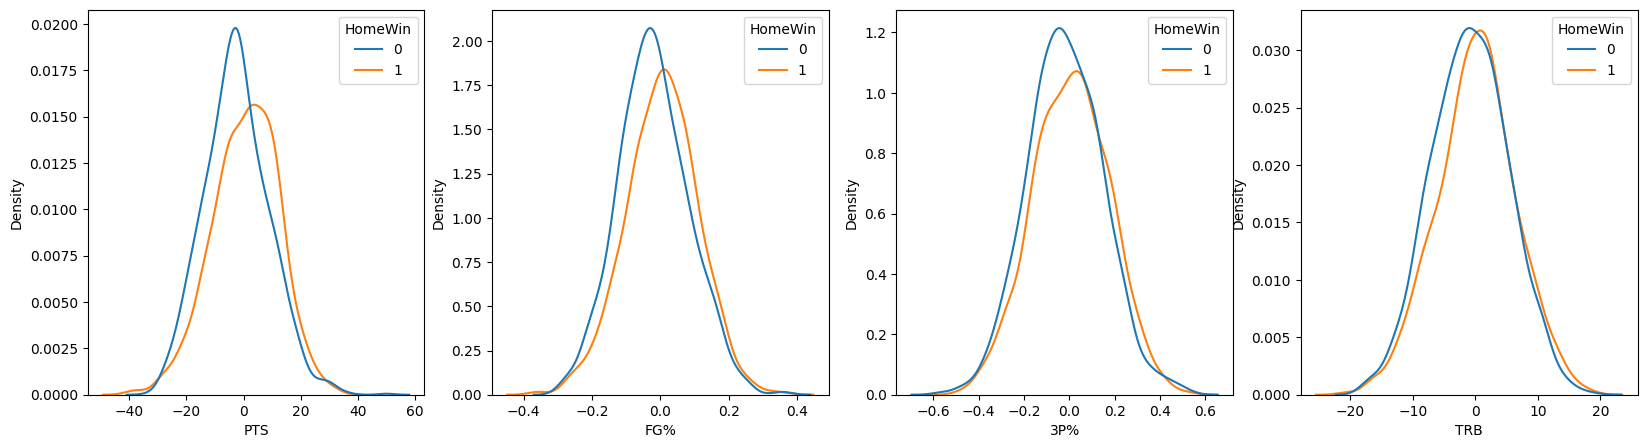

In [28]:
col_n = 4
row_n = 1

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*5))

for i,col in enumerate(basket_diff.columns[:-1]):
    sns.kdeplot(x=basket_diff[col],data=basket_diff, ax=ax[int(i%col_n)], hue="HomeWin")

  * 'PTS','FG%','3P%','TRB' 모두 수치가 큰 값 일수록 좋다.
  * 위 그래프에서 볼 수 있듯 홈팀의 승리/패배에 따라 주요 스탯의 분포가 약간씩 다르다는 것을 알 수 있으며, 홈팀이 승리한 경우 해당 feature의 차이가 더 오른쪽으로 치우친다. 이는 곧 승리했을 경우 해당 feature들에 대해 홈팀이 원정팀에 비해 더 높은 수치의 값을 가짐을 의미하고, 일반적인 해석과 일맥상통한다.

#### (2) feature 간 correlation 확인

<Axes: >

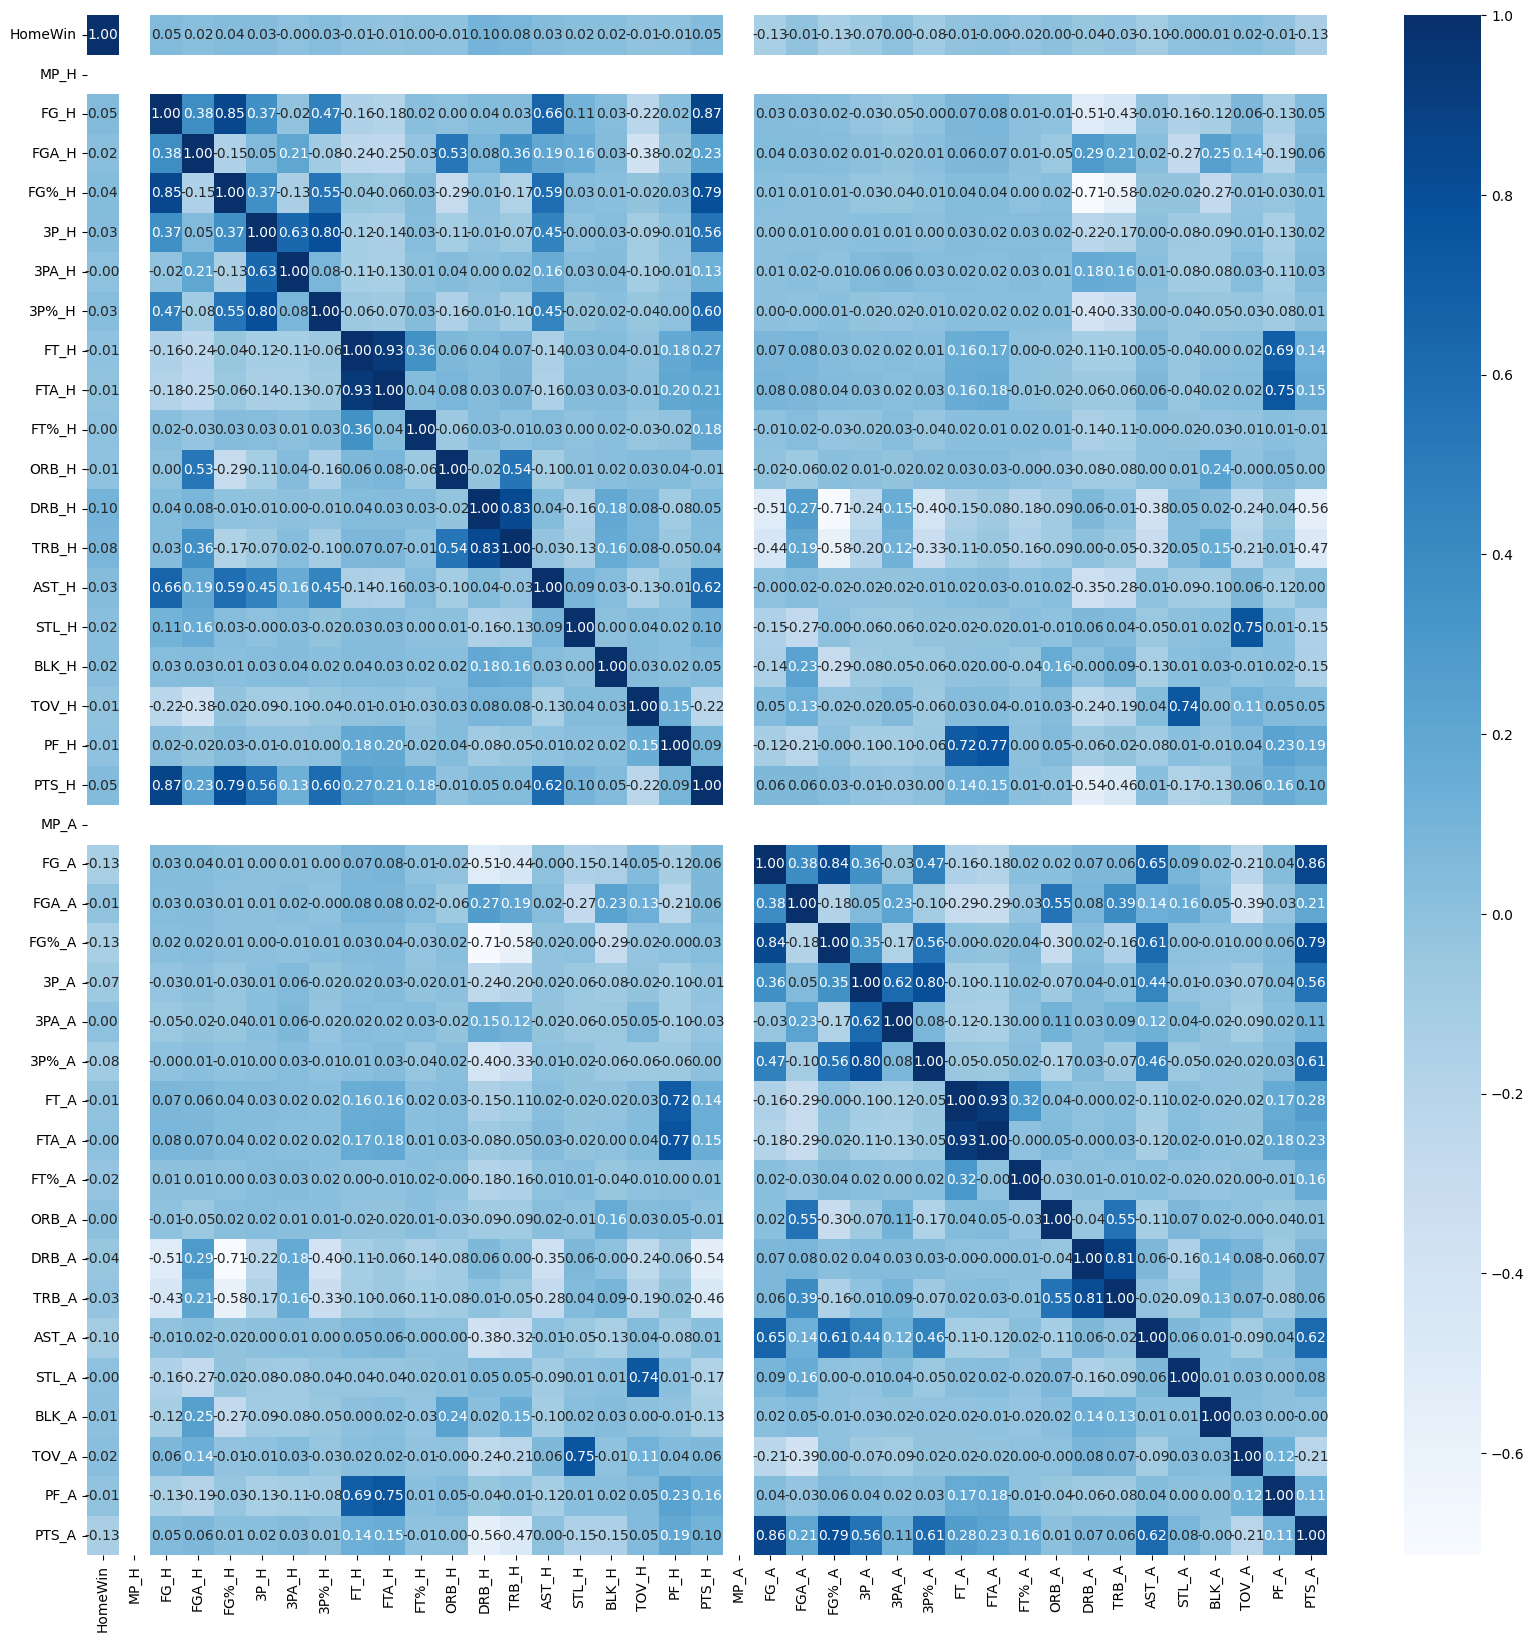

In [29]:
basket_corr=basket[2:].corr()
plt.figure(figsize=(20,20))
sns.heatmap(basket_corr, annot=True, fmt=".2f", cmap="Blues")

* correlation이 강한 몇몇 변수들이 보인다. 특히 3P,3PA,3P%와 같이 비슷한 경기 내용을 다루는 변수들 간의 상관관계가 비교적 크게 나타난다.

## **4. Data Preprocessing**

### **1) NA Imputation**

* NA값은 자유투 성공률을 의미하는 feature인 FT%_H 와 FT%_A에 존재하며, 자유투 시도가 없어 성공률이 NA인 경우이다.

* 실제 자유투를 시도했을 때의 성공률과 구분하기 위해 NA를 -1로 대체한다.

In [30]:
basket['FT%_H'][basket['FT%_H'].isna()]=-1.0
basket['FT%_A'][basket['FT%_A'].isna()]=-1.0

In [31]:
basket.isna().sum()

Team_H     0
Team_A     0
HomeWin    0
MP_H       0
FG_H       0
FGA_H      0
FG%_H      0
3P_H       0
3PA_H      0
3P%_H      0
FT_H       0
FTA_H      0
FT%_H      0
ORB_H      0
DRB_H      0
TRB_H      0
AST_H      0
STL_H      0
BLK_H      0
TOV_H      0
PF_H       0
PTS_H      0
MP_A       0
FG_A       0
FGA_A      0
FG%_A      0
3P_A       0
3PA_A      0
3P%_A      0
FT_A       0
FTA_A      0
FT%_A      0
ORB_A      0
DRB_A      0
TRB_A      0
AST_A      0
STL_A      0
BLK_A      0
TOV_A      0
PF_A       0
PTS_A      0
dtype: int64

### **2) Feature Engineering**

#### (1) MP 변수 삭제
  * 앞서 3-2) Features 에서 언급했듯, MP 변수는 총 출전시간을 의미하는 feature로 모든 경기에서 각팀이 120으로 일정한 값을 가진다. 따라서 해당 feature를 삭제한다.


In [32]:
basket=basket.drop(['MP_H','MP_A'],axis=1)

In [33]:
basket.shape

(2761, 39)

#### (2) 2점 야투에 대한 변수 생성 및 전체 야투 변수 삭제
  * 기존의 FG, FGA, FG% feature의 경우 2점 야투와 3점 야투를 모두 포함하는 feature이다. 그런데 3점 야투에 대한 feature가 3P, 3PA, 3P%로 따로 존재하는 만큼, 전체 야투에 대한 feature와 3점 야투에 대한 feature를 이용하여 2점 야투에 대한 feature 2P, 2PA, 2P%를 생성한다.
    * 2P = FG-3P
    * 2PA = FGA-3PA
    * 2P% = 2P/2PA
  * 2점 야투에 대한 feature들을 생성하고 나면 전체 야투에 대한 feature는 3점 야투에 대한 feature와 2점 야투에 대한 feature로 충분히 설명되므로 전체 야투에 대한 feature FG, FGA, FG%를 삭제한다.

In [34]:
basket['2P_H']=basket['FG_H']-basket['3P_H']
basket['2P_A']=basket['FG_A']-basket['3P_A']
basket['2PA_H']=basket['FGA_H']-basket['3PA_H']
basket['2PA_A']=basket['FGA_A']-basket['3PA_A']
basket['2P%_H']=basket['2P_H']/basket['2PA_H']
basket['2P%_A']=basket['2P_A']-basket['2PA_A']

In [35]:
basket=basket.drop(['FG_H','FG_A','FGA_H','FGA_A','FG%_H','FG%_A'],axis=1)
basket.columns

Index(['Team_H', 'Team_A', 'HomeWin', '3P_H', '3PA_H', '3P%_H', 'FT_H',
       'FTA_H', 'FT%_H', 'ORB_H', 'DRB_H', 'TRB_H', 'AST_H', 'STL_H', 'BLK_H',
       'TOV_H', 'PF_H', 'PTS_H', '3P_A', '3PA_A', '3P%_A', 'FT_A', 'FTA_A',
       'FT%_A', 'ORB_A', 'DRB_A', 'TRB_A', 'AST_A', 'STL_A', 'BLK_A', 'TOV_A',
       'PF_A', 'PTS_A', '2P_H', '2P_A', '2PA_H', '2PA_A', '2P%_H', '2P%_A'],
      dtype='object')

#### (3) ORB, DRB feature 삭제
  * 리바운드는 공격리바운드(ORB)인지 수비리바운드(DRB)인지와 관계 없이 공격권을 한번 더 가져오는 같은 역할을 한다는 점에서 총 리바운드 횟수인 TRB만 사용한다.

In [36]:
basket=basket.drop(['ORB_H','ORB_A','DRB_H','DRB_A'],axis=1)
basket.columns

Index(['Team_H', 'Team_A', 'HomeWin', '3P_H', '3PA_H', '3P%_H', 'FT_H',
       'FTA_H', 'FT%_H', 'TRB_H', 'AST_H', 'STL_H', 'BLK_H', 'TOV_H', 'PF_H',
       'PTS_H', '3P_A', '3PA_A', '3P%_A', 'FT_A', 'FTA_A', 'FT%_A', 'TRB_A',
       'AST_A', 'STL_A', 'BLK_A', 'TOV_A', 'PF_A', 'PTS_A', '2P_H', '2P_A',
       '2PA_H', '2PA_A', '2P%_H', '2P%_A'],
      dtype='object')

In [37]:
basket.shape

(2761, 35)

#### (4) Team feature 삭제
* 다음과 같은 이유로 각 팀을 나타내는 범주형 feature인 'Team_H'와 'Team_A'를 삭제한다.
  * 현재 basket 데이터 프레임의 feature가 매우 많은 편이고 전체 팀 수가 30개나 되기 때문에 one-hot encoding을 하기에는 무리가 있다고 판단하였다.
  * 본 프로젝트를 통해 구현하고자 하는 승부 예측 모델은 팀이 어떤 팀인지보다는 전반전의 세부 스탯을 중심으로 예측을 진행하는 것이 목적이다.

In [38]:
basket=basket.drop(['Team_H','Team_A'],axis=1)
basket.columns

Index(['HomeWin', '3P_H', '3PA_H', '3P%_H', 'FT_H', 'FTA_H', 'FT%_H', 'TRB_H',
       'AST_H', 'STL_H', 'BLK_H', 'TOV_H', 'PF_H', 'PTS_H', '3P_A', '3PA_A',
       '3P%_A', 'FT_A', 'FTA_A', 'FT%_A', 'TRB_A', 'AST_A', 'STL_A', 'BLK_A',
       'TOV_A', 'PF_A', 'PTS_A', '2P_H', '2P_A', '2PA_H', '2PA_A', '2P%_H',
       '2P%_A'],
      dtype='object')

### **3) Log Transformation**
  * right skewed된 형태의 분포를 가지는 BLK_H, BLK_A 변수를 log transformation 하여 정규성을 높여준다.

In [39]:
basket["BLK_H"] = np.log1p(basket["BLK_H"])
basket["BLK_A"] = np.log1p(basket["BLK_A"])

<Axes: xlabel='BLK_A', ylabel='Density'>

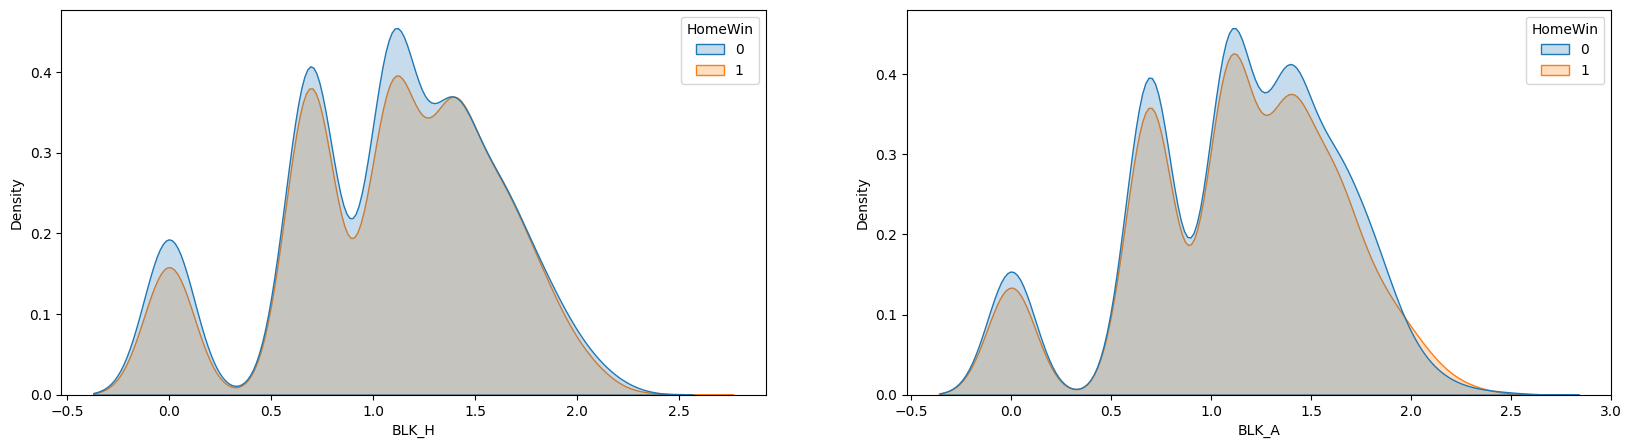

In [40]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,1*5))

sns.kdeplot(x='BLK_H', data=basket, hue="HomeWin",fill=True, ax=ax[0])
sns.kdeplot(x='BLK_A', data=basket, hue="HomeWin",fill=True,ax=ax[1])

### 4) Square Transformation

* left skewed 된 feature 인 'FT%_H'와 'FT%_A'를 square transformation을 통해 skweness를 완화시킨다.
* reference : https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55

<Axes: xlabel='FT%_A', ylabel='Density'>

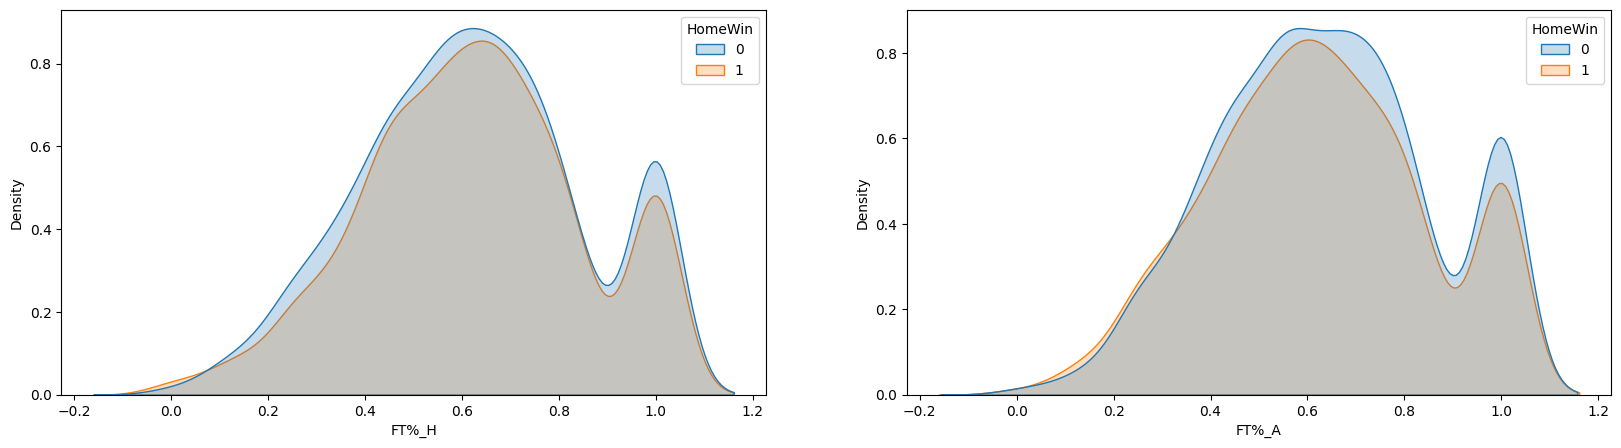

In [41]:
basket['FT%_H']=(basket['FT%_H'])**2
basket['FT%_A']=(basket['FT%_A'])**2

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,1*5))

sns.kdeplot(x='FT%_H', data=basket, hue="HomeWin",fill=True,ax=ax[0])
sns.kdeplot(x='FT%_A', data=basket, hue="HomeWin",fill=True,ax=ax[1])

### **5) Label 분리, Train/Test Dataset분리**
* 모델 훈련에 사용하기 위해 label feature인 'HomeWin'을 분리하고, 전체 데이터셋을 Train set과 Test set으로 분리한다.
* 전체 데이터의 25%를 test 데이터로 사용한다.

In [ ]:
y=basket['HomeWin']
X=basket.drop(['HomeWin'],axis=1)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

In [ ]:
y_train

1668    0
1516    1
339     0
2397    0
69      1
       ..
368     0
1749    0
1032    0
1698    1
2725    1
Name: HomeWin, Length: 2070, dtype: int64

### **6) PCA**

In [ ]:
X_train.shape

(2070, 32)

* feature의 수가 32개로 많은 편이기 때문에 차원을 축소하여 모델 적합에 사용할 수 있도록 PCA를 적용한 데이터셋을 생성한다.
* PCA를 적용할 것인지의 여부는 이후 모델을 적합해 보고 실험적으로 결정한다.

* principal component의 갯수를 결정하기 위해 X_train에 대해 pca를 진행한 후 각 principal component가 설명한는 분산의 양을 살펴본다.
 * reference : https://plotly.com/python/pca-visualization/

In [ ]:
pca = PCA()
pca.fit(X_train)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)


* 12개의 principal component로 전체 분산의 95%를 설명할 수 있다.
* 이후 사용하기 위해 n_component=12 로 차원축소한 데이터셋을 생성해둔다.

In [ ]:
pca=PCA(n_components=12)
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.transform(X_test)

print(X_train.shape, X_test.shape)
print(X_train_pca.shape, X_test_pca.shape)

(2070, 32) (691, 32)
(2070, 12) (691, 12)


## **5. Model Selection**

* 본 프로젝트의 목적은 두가지이다.

  (1) 2Q 종료 후(전반전 종료 후) 홈팀의 기대 승률 예측

  (2) 경기의 최종 승부 예측

### 1) Logistic Regression
  * Logistic Regression의 경우, 데이터가 각 클래스에 속할 확률을 모델링한다. 따라서 Logistic Regression을 사용하면 홈팀이 승리할 확률 즉, 홈팀의 기대 승률에 대한 예측값을 구할 수 있다.- (1)
  * 또한 threshold를 설정하여 기대 승률을 기반으로 승리 여부도 예측할 수 있다. threshold는 0.5로 설정하여 홈팀의 기대 승률이 0.5 이상일 경우 홈팀이 승리한다고 예측한다. - (2)
  * Logistic Regression은 본 프로젝트에서 진행하고자 하는 Binary calssification 에 매우 적합하다.
  * 만약 Logistic Regression에서 Lasso regularization을 적용하게 되면 feature selection을 기대할 수 있다.

### 2) RandomForest (Classification)

reference : 파이썬 머신러닝 완벽 가이드 (권철민/위키북스)

RandomForest는 Tree 기반의 앙상블 모델이다. Bagging방식을 사용하여 Train 데이터 셋으로부터 복원 추출을 통해 여러 개의 boostrap 데이터 셋을 만들고, 각 데이터셋에 대한 Decision tree를 만들어 결과를 예측한다. 분류 문제에서는 각 Decision 트리들의 결과를 voting하여 다수결로 최종결과를 선정한다.

### (1) Decision Tree
  * parent node에서 특정 feature에 대한 값을 기준으로 binary split을 진행한다. 이 때 split에 사용하는 feature와 split 기준은 child node의 imppurity 가 최소가 되도록 설정한다.
  * Decision tree가 Train data set에 대해 fitting되고 나면, 어떤 test data가 들어 왔을 때 그 data는 decision tree의 split 기준에 따라 root 노드 부터 터미널 노드까지 분기해냐간다. 데이터가 터미널 노드에 도달하면, 해당 터미널 노드에 속하는 train data 들 중 가장 많은 data가 해당하는 class로 test data의 class를 예측한다.

### (2) Bagging
  * 하나의 data로 부터 복원추출을 통해 여러 개의 boostrap data를 생성한다. 이후, 각 boostrap data 별로 각각 모델을 fitting한다. 이후 test data가 들어 오면 각 모델의 예측 class를 다수결 원칙으로 투표하여 최종 예측 class를 결정한다.

랜덤포레스트는 Bagging방식을 사용하며, 이 때 각 Boostrap data를 이용하여 fitting하는 각각의 모델이 Decision Tree인 경우를 말한다. Decision Tree에서는 임의로 선택된 일부의 feature를 사용하여 split을 진행한다.


  
* sklearn의 RandomForestClassifier는 predict_proba() 메소드를 제공한다. fitting된 RandomForestClassifier에서 해당 메소드를 사용하면 데이터가 특정 class로 예측될 확률을 return한다. 따라서 기대 승률에 대한 예측값을 구할 수 있다. -(1)

* RandomForestClassifier의 예측 결과를 가지고 승부 예측 또한 진행할 수 있다. -(2)

## **6. Evaluation Metric**

다음과 같은 총 4개의 evalutaion metric을 고려한다.

* Accuracy
  * Accuracy = (True Positive + True Negative)/(Total number of data)
  * 올바르게 예측한 데이터의 비율
* Precision
  * Precision = (True Positive)/(True Positive + False Positive)
  * True로 예측한 data 중 실제로도 True인 데이터의 비율
* Recall
  * Recall=(True Positive)/(True Positive + False Negative)
  * 실제로 True인 data 중 True로 예측한 데이터의 비율
* f1-score
  * fl-score = 2*(precision x recall)/(precision + recall)
  * precision과 recall을 함께 고려한 metric

* 본 프로젝트에서는 단순히 전반전만의 데이터를 가지고 승부를 예측하고, 실제로 그것이 의미있는지를 확인하는 것이 목적이기 때문에 승리를 패배로 잘못 예측하거나, 패배를 승리로 잘못 예측하는 것에 대해 두 경우의 가중치를 다르게 설정할 필요가 없다. 즉, precision과 recall이 큰 의미가 없다. 따라서 accuracy를 중점적으로 model을 평가한다.
  * 예를 들어 암 여부를 판단하는 경우에는 실제로 암인 데이터를 암이 아니라고 예측하지 않는 것(recall)이 암이라고 예측한 데이터 중에서 암이 아닌 데이터가 포함되지 않는 것(precision)보다 중요하다.
  * Hyper parameter tuning도 accuracy를 사용하여 진행한다.

## **7. Model Fitting - Logistic Regression**

### **1) Hyper Parameter Tuning**

In [ ]:
logistic=LogisticRegression(solver='sag')
param_logistic={'C': [0,0.001, 0.01, 0.1, 1, 10, 100], 'penalty' : ['l2','l1','none']}
grid_logistic=GridSearchCV(logistic,param_grid=param_logistic, cv=5, refit=True)
grid_logistic.fit(X_train,y_train)
print("best_param:",grid_logistic.best_params_)
print("mean cv of best parameter:",grid_logistic.best_score_)

best_param: {'C': 0.001, 'penalty': 'l2'}
mean cv of best parameter: 0.5545893719806763


* training cv error는 0.55 정도이고, parameter는 'C':0.001, 'penalty':'l2'가 선택되었다.
* LogisticRegression객체의 solver parameter는 optimization하는 방법을 지정하는 parameter이다.  scikit learn의 LogisticRegrission 문서를 참고하여 Stochastic Average Gradient descent 방법을 사용하는 sag를 sovler로 지정하였다.
* reference : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### **2) 기대 승률 예측**
  * hyper parameter를 사용한 Logistic Regression 모델에서 예측한 test data에 대한 2Q 종료 후 기대 승률은 다음과 같다.

In [ ]:
estimator_logistic=LogisticRegression(C=0.001,penalty='l2',solver='sag')
estimator_logistic.fit(X_train,y_train)
probability=estimator_logistic.predict_proba(X_test)
probability

array([[0.64698694, 0.35301306],
       [0.52414946, 0.47585054],
       [0.48851087, 0.51148913],
       ...,
       [0.40017231, 0.59982769],
       [0.56651144, 0.43348856],
       [0.51804144, 0.48195856]])

In [ ]:
estimator_logistic.classes_

array([0, 1])

* estimator_logistic 클래스 내에서 classes가 0,1 순서로 설정되어 있으므로 probability의 첫번째 열이 홈팀이 패배할 확률이고, 두번째 열이 홈팀이 승리할 확률 즉, 기대 승률이다.

* 각 test data에 대한 홈팀의 2Q 종료 후 기대 승률은 다음과 같다.

In [ ]:
probability[:,1]

array([0.35301306, 0.47585054, 0.51148913, 0.35990115, 0.47096339,
       0.4842335 , 0.52607434, 0.54017505, 0.56257199, 0.43284846,
       0.43740339, 0.41228307, 0.5459819 , 0.57445722, 0.56327061,
       0.65424714, 0.48233288, 0.49123786, 0.47591732, 0.55652289,
       0.50815968, 0.56111771, 0.46584105, 0.37527685, 0.46114096,
       0.50342211, 0.40189986, 0.52505417, 0.49069156, 0.60363653,
       0.3989294 , 0.49204386, 0.42883911, 0.51962461, 0.62004671,
       0.43357948, 0.35607034, 0.38598535, 0.4352544 , 0.3965422 ,
       0.36417908, 0.50447231, 0.40490148, 0.51541714, 0.35864286,
       0.46646202, 0.48534554, 0.34966741, 0.47710059, 0.37533053,
       0.44529349, 0.53446514, 0.39555551, 0.60320866, 0.4835296 ,
       0.43412405, 0.59565309, 0.4378337 , 0.4497465 , 0.56897242,
       0.46530851, 0.53856646, 0.28159158, 0.47635538, 0.41594352,
       0.5531027 , 0.3978185 , 0.49993283, 0.49589662, 0.53968855,
       0.53270209, 0.40195956, 0.58828236, 0.45335495, 0.47089

### **3) 승부 예측**

* LogisticRegression Classifier의 예측 확률(predict_proba)을 사용한 승부 예측

In [ ]:
preds_logistic=estimator_logistic.predict(X_test)
preds_logistic

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,

* LogisticRegression 클래스는 기대 승률 예측에서 구한 확률값(probability)을 사용하여, 기대 승률이 이 0.5보다 작으면 0(홈팀 패배)로 분류하고, 0.5보다 크면 1(홈팀 승리)로 분류한다. 즉, probability의 두번째 열의 값인 홈팀의 기대 승률이 0.5보다 크면 홈팀 승리로 예측하고, 그렇지 않으면 홈팀 패배로 예측한다.

### **4) 승부 예측에 대한 Model Evaluation**

In [ ]:
accuracy_list=[]
precision_list=[]
recall_list=[]
f1_list=[]

for i in range(3):
  estimator_logistic=LogisticRegression(C=0.001,penalty='l2',solver='sag')
  estimator_logistic.fit(X_train,y_train)
  print("\n",estimator_logistic.coef_,"\n")
  preds_logistic=estimator_logistic.predict(X_test)

  test_accuracy_logistic=accuracy_score(preds_logistic,y_test)
  accuracy_list.append(test_accuracy_logistic)

  precision_list.append(precision_score(preds_logistic, y_test))
  recall_list.append(recall_score(preds_logistic, y_test))
  f1_list.append(f1_score(preds_logistic, y_test))

  print(i+1," test accuracy of logistic : ",test_accuracy_logistic)


 [[ 9.12533873e-03  5.60376414e-04 -1.11697359e-03 -3.87546931e-03
  -8.07143444e-03 -2.11196070e-03 -4.60400434e-03 -1.94398783e-03
  -1.53431779e-02 -4.63153469e-03  8.35134797e-03  3.54487545e-03
   1.54705671e-02 -5.70934969e-03  2.46324670e-02  3.96304019e-04
   1.27562649e-03 -6.49678654e-03  5.33149301e-06  4.73387348e-03
  -1.81103140e-03  1.42874407e-02  4.93310425e-03  2.71644037e-03
   1.35810072e-02 -3.12391604e-02 -4.01498990e-03 -7.69336889e-03
   1.29030950e-02  1.56874144e-03 -9.03785048e-04 -9.26211033e-03]] 

1  test accuracy of logistic :  0.5426917510853835

 [[ 9.12534162e-03  5.49972227e-04 -1.11933546e-03 -3.87237516e-03
  -8.07114459e-03 -2.11698333e-03 -4.60751382e-03 -1.94539895e-03
  -1.53438823e-02 -4.63535790e-03  8.34014945e-03  3.54233608e-03
   1.54680512e-02 -5.70850804e-03  2.46226630e-02  3.96840067e-04
   1.27745864e-03 -6.50053406e-03 -2.90677495e-06  4.72722808e-03
  -1.81180691e-03  1.42876550e-02  4.94461601e-03  2.71102195e-03
   1.35727894e-02

* Confusion Matrix of last testing

In [ ]:
confusion_matrix(y_test, preds_logistic)

array([[233, 126],
       [190, 142]])

In [ ]:
print("accuracy list : ",accuracy_list)
print("mean of test accuracy : ",np.mean(accuracy_list))
print("variance of test accuracy : ", np.var(accuracy_list))

accuracy list :  [0.5426917510853835, 0.5426917510853835, 0.5426917510853835]
mean of test accuracy :  0.5426917510853835
variance of test accuracy :  0.0


* train data를 fit할 때마다 coefficient가 아주 약간씩 달라지지만 예측 결과는 변하지 않는다. 이에 따라 predict accuracy가 계속 같은 값이 나온다.
* 모델의 평균 test accuracy는 0.5426917510853835 이고 variance는 0이다.

* **모델의 예측 정확도가 그리 높지 않다.**

In [ ]:
print("precision list : ",precision_list)
print("mean of test precision : ",np.mean(precision_list))

precision list :  [0.42771084337349397, 0.42771084337349397, 0.42771084337349397]
mean of test precision :  0.42771084337349397


In [ ]:
print("recall list : ",recall_list)
print("mean of test recall : ",np.mean(recall_list))

recall list :  [0.5298507462686567, 0.5298507462686567, 0.5298507462686567]
mean of test recall :  0.5298507462686567


In [ ]:
print("f1 list : ",f1_list)
print("mean of test f1 : ",np.mean(f1_list))

f1 list :  [0.47333333333333333, 0.47333333333333333, 0.47333333333333333]
mean of test f1 :  0.47333333333333333


* accuracy, recall에 비해 precision이 낮게 나온다.

### **5) 특정 경기에 대한 기대 승률 및 승부 예측**

어떤 한 경기에 대한 기대승률 및 승부를 예측하고 싶다면 다음과 같은 과정을 거치면 된다. 아래 예시는 2015년 2월 11일에 치러진 Golden State Warriors (Home) 과 Minnesota Timberwolves (Away)의 경기의 전반전 세부 스탯 데이터에 대한 기대 승률 및 승부 예측과정이다.

In [ ]:
# 1. 데이터 입력
test_match_stat=pd.DataFrame(columns=['Team_H','Team_A',
                            'MP_H','FG_H','FGA_H','FG%_H','3P_H','3PA_H','3P%_H','FT_H','FTA_H','FT%_H','ORB_H','DRB_H','TRB_H','AST_H','STL_H','BLK_H','TOV_H','PF_H','PTS_H',
                           'MP_A','FG_A','FGA_A','FG%_A','3P_A','3PA_A','3P%_A','FT_A','FTA_A','FT%_A','ORB_A','DRB_A','TRB_A','AST_A','STL_A','BLK_A','TOV_A','PF_A','PTS_A'])
test_match_stat.loc[0]=['GSW','MIN',120,24,46,.522,4,14,.286,4,5,.800,7,21,28,15,4,3,11,7,56, 120,18,46,.391,4,10,.400,6,8,.750,6,14,20,11,5,0,8,7,46]
test_match_stat

#2. data Preprocessing

#1) NA imputation
if(test_match_stat['FT%_H'].empty):
  test_match_stat['FT%_H']= -1.0
if(test_match_stat['FT%_A'].empty):
  test_match_stat['FT%_A']= -1.0

#2) MP 변수 삭제
test_match_stat=test_match_stat.drop(['MP_H','MP_A'],axis=1)

#3) 2점 야투에 대한 변수 생성 및 전체 야투 변수 삭제
test_match_stat['2P_H']=test_match_stat['FG_H']-test_match_stat['3P_H']
test_match_stat['2P_A']=test_match_stat['FG_A']-test_match_stat['3P_A']
test_match_stat['2PA_H']=test_match_stat['FGA_H']-test_match_stat['3PA_H']
test_match_stat['2PA_A']=test_match_stat['FGA_A']-test_match_stat['3PA_A']
test_match_stat['2P%_H']=test_match_stat['2P_H']/test_match_stat['2PA_H']
test_match_stat['2P%_A']=test_match_stat['2P_A']-test_match_stat['2PA_A']
test_match_stat=test_match_stat.drop(['FG_H','FG_A','FGA_H','FGA_A','FG%_H','FG%_A'],axis=1)

#4) ORB,DRB, Team feature 삭제
test_match_stat=test_match_stat.drop(['ORB_H','ORB_A','DRB_H','DRB_A','Team_H','Team_A'],axis=1)

#4) Log Transformation, Square Transformation
test_match_stat["BLK_H"] = np.log1p(test_match_stat["BLK_H"][0])
test_match_stat["BLK_A"] = np.log1p(test_match_stat["BLK_A"][0])
test_match_stat['FT%_H']=(test_match_stat['FT%_H'])**2
test_match_stat['FT%_A']=(test_match_stat['FT%_A'])**2

#3. Fit 되어 있는 모델 사용하여 Predict
probability_of_victory=estimator_logistic.predict_proba(test_match_stat)
print("홈팀의 2Q 종료 후 기대 승률 : ",probability_of_victory[0][1])
predict_of_victory=estimator_logistic.predict(test_match_stat)
if(predict_of_victory==1):
  print("승부 예측 - Home Team 승리 ")
else:
  print("승부 예측 - Away Team 승리")


홈팀의 2Q 종료 후 기대 승률 :  0.559820671508155
승부 예측 - Home Team 승리 


* 참고로, 해당 경기는 Golden Staete Worriers (Home)가 94:91로 승리하였다.

## **8. Model Fitting - RandomForest**

* reference :https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### **1) Hyper Parameter Tuning**

In [ ]:
# define parameter search space
param_grid = {'n_estimators': [100, 200, 350],
              'min_samples_leaf': [2, 10, 30],
              'max_depth':[3,6,9],
              'max_features': ['auto', 'sqrt'],
              'criterion': ['gini', 'entropy']}
clf = RandomForestClassifier()
grid_rf = GridSearchCV(clf, param_grid, refit = True, cv=5, verbose = 3, scoring='accuracy')

# fit the model for grid search
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=100;, score=0.560 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=100;, score=0.560 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=100;, score=0.560 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=100;, score=0.606 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=100;, score=0.575 total time=   0.3s
[CV 1/5] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=200;, score=0.553 total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=200;, score=0.560 total time=   0.5s
[CV 3/5] END criteri

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 9],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [100, 200, 350]},
             scoring='accuracy', verbose=3)

In [ ]:
print("best params:",grid_rf.best_params_)
print("best cv error : ", grid_rf.best_score_)


best params: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 30, 'n_estimators': 100}
best cv error :  0.5893719806763286


* training cv error는 0.59 정도이고, parameter는 {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 30, 'n_estimators': 100} 이 선택되었다.
  * max_depth : 트리의 깊이, 트리가 깊을 수록 모델이 복잡해진다.
  * criterion : 각 트리의 split에서 child node의 impurity를 계산하는 지표.
  * max_features : 각 트리에서 사용할 feature의 갯수
  * min_samples_leaf : 각 트리의 터미널 노드에 속하는 data의 최소 갯수. split 시 min_samples_leaf에 도달하면 split을 멈춘다,
  * n_estimators : 생성할 tree의 갯수

### **2) 기대 승률 예측**
  * hyper parameter를 사용한 RandomForest 모델에서 예측한 test data에 대한 2Q 종료 후 기대 승률은 다음과 같다.

In [ ]:
estimator_rf=grid_rf.best_estimator_
estimator_rf.fit(X_train,y_train)
probability_rf=estimator_rf.predict_proba(X_test)
probability_rf

array([[0.64400171, 0.35599829],
       [0.50817636, 0.49182364],
       [0.50013343, 0.49986657],
       ...,
       [0.70202192, 0.29797808],
       [0.36147765, 0.63852235],
       [0.51698947, 0.48301053]])

In [ ]:
estimator_rf.classes_

array([0, 1])

* estimator_rf 클래스 내에서 classes가 0,1 순서로 설정되어 있으므로 probability의 첫번째 열이 홈팀이 패배할 확률이고, 두번째 열이 홈팀이 승리할 확률 즉, 홈팀의 기대 승률이다.

* 각 test data에 대한 홈팀의 2Q 종료 후 기대 승률은 다음과 같다.

In [ ]:
probability_rf[:,1]

array([0.35599829, 0.49182364, 0.49986657, 0.45663314, 0.46976501,
       0.51590024, 0.51642517, 0.46747815, 0.63656974, 0.43451505,
       0.41701021, 0.58749614, 0.52912674, 0.32499146, 0.32022851,
       0.63721677, 0.57420798, 0.66205748, 0.66600494, 0.49473341,
       0.52577581, 0.49969655, 0.44294361, 0.48549515, 0.30140483,
       0.37365997, 0.34635051, 0.5216595 , 0.48881413, 0.49345581,
       0.50793734, 0.52900236, 0.51888013, 0.54010171, 0.53182154,
       0.50539748, 0.35691523, 0.52651247, 0.50691653, 0.5269829 ,
       0.53335435, 0.48148737, 0.48078299, 0.44772168, 0.50034031,
       0.50706701, 0.34994628, 0.53541929, 0.33096166, 0.53700831,
       0.55390253, 0.55656629, 0.53527884, 0.49419243, 0.36795891,
       0.63855235, 0.51500078, 0.48934572, 0.49112488, 0.35322953,
       0.56364648, 0.3859328 , 0.50297022, 0.51801019, 0.65925378,
       0.53098449, 0.3743127 , 0.64034172, 0.54398613, 0.50963933,
       0.48353989, 0.47730722, 0.31259712, 0.48985688, 0.46759

### **3) 승부 예측**

#### (1) pca 적용하지 않은 데이터 사용 (estimator_rf)

* RandomForest Classifier의 예측 결과

In [ ]:
estimator_rf=RandomForestClassifier(criterion='gini', max_depth= 6, max_features= 'auto', min_samples_leaf= 30, n_estimators= 100)
estimator_rf.fit(X_train,y_train)
preds_rf=estimator_rf.predict(X_test)
preds_rf

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,

#### (1)-2. Feature importance 확인
* RandomForest와 같은 tree기반 모델의 경우, feature importance attribute을 제공한다. 이 feature importance는 해당 feature가 예측에서 빠졌을 때 모델 성능이 얼마나 나빠지는지를 이용하여 측정한다.

* reference : https://github.com/MazeLearner/MachineLearning2022/blob/main/MachineLearning_TeamProject_MazeLearner.ipynb

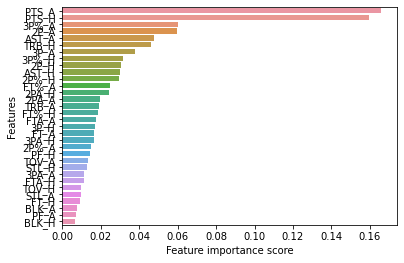

PTS_A    0.166005
PTS_H    0.159653
3P%_A    0.060389
2P_A     0.059598
AST_A    0.047565
dtype: float64


In [ ]:
feature_scores = pd.Series(estimator_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

f, ax = plt.subplots()
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

print(feature_scores[:5])

* 홈팀과 원정팀의 전반 득점이 가장 많은 영향을 미치는 것으로 보인다.

#### (2) PCA를 적용한 데이터 사용 (estimator_rf_pca)

* RandomForest Classifier의 승부 예측 결과

In [ ]:
estimator_rf_pca=RandomForestClassifier(criterion='gini', max_depth= 6, max_features= 'auto', min_samples_leaf= 30, n_estimators= 100)
estimator_rf_pca.fit(X_train_pca,y_train)
preds_rf_pca=estimator_rf_pca.predict(X_test_pca)
preds_rf_pca

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,

### **4) 승부 예측에 대한 Model Evaluation**

#### (1) PCA를 적용하지 않은 데이터 사용 (estimator_rf)

In [ ]:
accuracy_list=[]
precision_list=[]
recall_list=[]
f1_list=[]

for i in range(3):
  estimator_rf.fit(X_train,y_train)
  preds_rf=estimator_rf.predict(X_test)

  test_accuracy_rf=accuracy_score(preds_rf,y_test)
  accuracy_list.append(test_accuracy_rf)

  precision_list.append(precision_score(preds_rf, y_test))
  recall_list.append(recall_score(preds_rf, y_test))
  f1_list.append(f1_score(preds_rf, y_test))



* Confusion Matrix of last testing

In [ ]:
confusion_matrix(y_test, preds_rf)

array([[228, 147],
       [148, 168]])

In [ ]:
print("accuracy list : ",accuracy_list)
print("mean of test accuracy : ",np.mean(accuracy_list))
print("variance of test accuracy : ", np.var(accuracy_list))

accuracy list :  [0.5701881331403763, 0.5788712011577424, 0.573082489146165]
mean of test accuracy :  0.5740472744814279
variance of test accuracy :  1.3031350403936758e-05


* train data를 fit할 때마다 예측 결과가 약간씩 달라지고, 이에 따라 predict accuracy도 아주 약간씩 달라진다.
* 모델의 평균 test accuracy는 0.5740472744814279 이고 variance는 1.3031350403936758e-05으로 0에 가깝다.

* **모델의 예측 정확도가 그리 높지 않다.**

In [ ]:
print("precision list : ",precision_list)
print("mean of test precision : ",np.mean(precision_list))

precision list :  [0.5, 0.5474683544303798, 0.5316455696202531]
mean of test precision :  0.5263713080168776


In [ ]:
print("recall list : ",recall_list)
print("mean of test recall : ",np.mean(recall_list))

recall list :  [0.531986531986532, 0.5389408099688473, 0.5333333333333333]
mean of test recall :  0.5347535584295708


In [ ]:
print("f1 list : ",f1_list)
print("mean of test f1 : ",np.mean(f1_list))

f1 list :  [0.5154975530179445, 0.543171114599686, 0.5324881141045957]
mean of test f1 :  0.5303855939074088


#### (2) PCA를 적용한 데이터 사용 (estimator_rf_pca)

In [ ]:
accuracy_list_pca=[]
precision_list_pca=[]
recall_list_pca=[]
f1_list_pca=[]

for i in range(3):
  estimator_rf_pca.fit(X_train_pca,y_train)
  preds_rf_pca=estimator_rf_pca.predict(X_test_pca)

  test_accuracy_rf_pca=accuracy_score(preds_rf_pca,y_test)
  accuracy_list_pca.append(test_accuracy_rf_pca)

  precision_list_pca.append(precision_score(preds_rf_pca, y_test))
  recall_list_pca.append(recall_score(preds_rf_pca, y_test))
  f1_list_pca.append(f1_score(preds_rf_pca, y_test))


* Confusion Matrix of last testing

In [ ]:
confusion_matrix(y_test, preds_rf_pca)

array([[240, 135],
       [155, 161]])

In [ ]:
print("accuracy list : ",accuracy_list_pca)
print("mean of test accuracy : ",np.mean(accuracy_list_pca))
print("variance of test accuracy : ", np.var(accuracy_list_pca))

accuracy list :  [0.5904486251808972, 0.5745296671490593, 0.5803183791606368]
mean of test accuracy :  0.5817655571635311
variance of test accuracy :  4.328269955593365e-05


* train data를 fit할 때마다 예측 결과가 약간씩 달라지고, 이에 따라 predict accuracy도 달라진다.
* 모델의 평균 test accuracy는 0.5817655571635311 이고 variance는 4.328269955593365e-05 이다.

* **모델의 예측 정확도가 그리 높지 않다.**

In [ ]:
print("precision list : ",precision_list_pca)
print("mean of test precision : ",np.mean(precision_list_pca))

precision list :  [0.5537974683544303, 0.5221518987341772, 0.509493670886076]
mean of test precision :  0.5284810126582279


In [ ]:
print("recall list : ",recall_list_pca)
print("mean of test recall : ",np.mean(recall_list_pca))

recall list :  [0.5520504731861199, 0.5357142857142857, 0.543918918918919]
mean of test recall :  0.5438945592731081


In [ ]:
print("f1 list : ",f1_list_pca)
print("mean of test f1 : ",np.mean(f1_list_pca))

f1 list :  [0.5529225908372828, 0.5288461538461539, 0.5261437908496733]
mean of test f1 :  0.5359708451777033


예측 정확도의 경우 PCA를 사용했을 때가 약간 더 높고, 나머지 수치들은 거의 비슷하다. 따라서 RandomForest를 이용한 분류에는 PCA를 적용한 데이터를 사용하기로 결정하였다.

### **5) 특정 경기에 대한 기대 승률 및 승부 예측**

어떤 한 경기에 대한 기대승률 및 승부를 예측하고 싶다면 다음과 같은 과정을 거치면 된다. 아래 예시는 2015년 2월 11일에 치러진 Golden State Warriors (Home) 과 Minnesota Timberwolves (Away)의 경기의 전반전 세부 스탯 데이터에 대한 기대 승률 및 승부 예측과정이다.

In [ ]:
# 1. 데이터 입력
test_match_stat=pd.DataFrame(columns=['Team_H','Team_A',
                            'MP_H','FG_H','FGA_H','FG%_H','3P_H','3PA_H','3P%_H','FT_H','FTA_H','FT%_H','ORB_H','DRB_H','TRB_H','AST_H','STL_H','BLK_H','TOV_H','PF_H','PTS_H',
                           'MP_A','FG_A','FGA_A','FG%_A','3P_A','3PA_A','3P%_A','FT_A','FTA_A','FT%_A','ORB_A','DRB_A','TRB_A','AST_A','STL_A','BLK_A','TOV_A','PF_A','PTS_A'])
test_match_stat.loc[0]=['GSW','MIN',120,24,46,.522,4,14,.286,4,5,.800,7,21,28,15,4,3,11,7,56, 120,18,46,.391,4,10,.400,6,8,.750,6,14,20,11,5,0,8,7,46]
test_match_stat

#2. data Preprocessing

#1) NA imputation
if(test_match_stat['FT%_H'].empty):
  test_match_stat['FT%_H']= -1.0
if(test_match_stat['FT%_A'].empty):
  test_match_stat['FT%_A']= -1.0

#2) MP 변수 삭제
test_match_stat=test_match_stat.drop(['MP_H','MP_A'],axis=1)

#3) 2점 야투에 대한 변수 생성 및 전체 야투 변수 삭제
test_match_stat['2P_H']=test_match_stat['FG_H']-test_match_stat['3P_H']
test_match_stat['2P_A']=test_match_stat['FG_A']-test_match_stat['3P_A']
test_match_stat['2PA_H']=test_match_stat['FGA_H']-test_match_stat['3PA_H']
test_match_stat['2PA_A']=test_match_stat['FGA_A']-test_match_stat['3PA_A']
test_match_stat['2P%_H']=test_match_stat['2P_H']/test_match_stat['2PA_H']
test_match_stat['2P%_A']=test_match_stat['2P_A']-test_match_stat['2PA_A']
test_match_stat=test_match_stat.drop(['FG_H','FG_A','FGA_H','FGA_A','FG%_H','FG%_A'],axis=1)

#4) ORB,DRB, Team feature 삭제
test_match_stat=test_match_stat.drop(['ORB_H','ORB_A','DRB_H','DRB_A','Team_H','Team_A'],axis=1)

#4) Log Transformation, Square Transformation
test_match_stat["BLK_H"] = np.log1p(test_match_stat["BLK_H"][0])
test_match_stat["BLK_A"] = np.log1p(test_match_stat["BLK_A"][0])
test_match_stat['FT%_H']=(test_match_stat['FT%_H'])**2
test_match_stat['FT%_A']=(test_match_stat['FT%_A'])**2

#5) PCA
test_match_stat=pca.transform(test_match_stat)

#3. Fit 되어 있는 모델 사용하여 Predict
probability_of_victory=estimator_rf_pca.predict_proba(test_match_stat)
print("홈팀의 2Q 종료 후 기대 승률 : ",probability_of_victory[0][1])
predict_of_victory=estimator_rf_pca.predict(test_match_stat)
if(predict_of_victory==1):
  print("승부 예측 - Home Team 승리 ")
else:
  print("승부 예측 - Away Team 승리")


홈팀의 2Q 종료 후 기대 승률 :  0.5164327074595508
승부 예측 - Home Team 승리 


* 참고로, 해당 경기는 Golden Staete Worriers (Home)가 94:91로 승리하였다.

## **9. Conclusion**

Logistic Regression과 RandomForest모델을 사용하여 승리/패배 각 클래스로 분류될 확률을 기대 승률로 간주함으로써 **전반전의 세부 스탯**으로 **2Q 종료 이후 기대 승률**을 구할 수 있었다. 본인은 평소 궁금했던 전반전의 스탯을 이용한 2Q 종료 이후 기대 승률을 계산하는 과정을 직접 구현해보았다는 점에 이 프로젝트의 의의를 두고 싶다.


Experiments의 결과로부터, logsitic Regression 모델보다 PCA를 적용한 경우의 RandomForest모델이 경기 결과를 더 잘 예측하고 있음을 알 수 있다.
  * Logistic Regression의 평균 예측 정확도 : 0.5426917510853835
  * RandomForest의 평균 예측 정확도 (PCA적용) : 0.5817655571635311


하지만 Logistic Regression과 SVM 모델 모두 승부 예측의 accuracy가 그렇게 높게 나오지 않았다. 이는 사실, 본인이 프로젝트를 진행하며 얻고자 했던 결과와 같다. 본 프로젝트의 결과는 전반전의 스탯만 가지고는 최종 경기 결과를 잘 예측할 수 없음을 보여주고 있다. 당연한 이야기다. 스포츠는 끝날 때 까지 끝난게 아니기 때문이다. 만약 전반전의 경기 내용만 가지고 승부를 잘 예측할 수 있다면 이는 곧 후반전은 할 필요가 없다는 이야기가 된다. 하지만 실제 경기에서 전반전이 끝났다는 것은 이제 고작 반이 끝났을 뿐인 것이고, 남은 후반전동안 어떤 일이 벌어질지는 그 누구도 알 수없다. 그것이 바로 우리가 스포츠에 열광하는 이유이다.

 그럼에도 불구하고, 에측 정확도가 0.5를 약간 웃도는 값을 가지는 이유는, 전반전이 후반전에도 영향을 미칠 수 있기 때문으로 보인다. 전반전의 세부 스탯에는 흔히들 '슛감' 이라고 말하는 것과 같은 선수들의 컨디션이 반영되었을 것이고, 그러한 컨디션은 후반에도 이어질 가능성이 높기 때문이다.

이러한 점에서 착안하여, 반대로 후반전의 데이터만 가지고 같은 방식으로 승부 예측을 진행해보는 것도 좋을 듯 하다. 해당 결과와 본 프로젝트의 결과를 비교해 본다면 전반전의 스탯과 후반전의 스탯 중 어느것이 승부에 더 영향을 많이 미칠지도 추론해 볼 수 있을 것으로 보인다.

또 본 프로젝트에는 몇가지 아쉬운 점이 존재한다. 추후 아래와 같은 아쉬운 점들을 보완하여 더 좋은 프로젝트로 발전시키고자 한다.
  * 시간상의 문제로 좀 더 많은 데이터를 수집하지 못했다. 분석에 사용하는 feature의 갯수에 비해 데이터의 수가 적다. 이에, 추가적으로 데이터를 수집하여 같은 분석을 진행해보면 좋을 듯 하다.
  * 시즌을 나타내는 feature가 없어 해당 경기가 어떤 시즌에 진행된 경기인지가 반영되지 않았다.
  * 경기를 치르는 팀에 대한 정보가 반영되지 않았다. 앞서 Feature Engineering에서 기술한 이유 외에도, 각 (홈 팀, 원정 팀) 순서쌍에 대한 경기 데이터가 충분하지 않다는 이유 때문에 Team feature를 삭제하였다. 하지만 각 팀들 사이에는 분명히 상대 전적이 존재하고, 눈에 보이지는 않지만 '상성'이라는 것이 존재한다. 따라서 보다 많은 데이터를 수집함으로써 경기를 치르는 팀들의 관계나 팀별 특성까지 반영할 수 있다면 보다 좋은 프로젝트가 될 것이다.